# **4.8 - RNN para a previsão de manchas solares** 🌠🌞
**Objetivo**: implementar uma rede neural recorrente (RNN) utilizando PyTorch ou lightning. Treine esta rede neural em um conjunto de dados sequenciais. Explique para o leitor como funciona a recorrência de uma RNN e o motivo de utilizarmos este tipo de arquitetura quando estudamos dados sequenciais.

**Dupla**: Eloísa Maria Amador Souza & Júlia Guedes A. dos Santos

**Contribuição de cada membro**: Ambas contribuíram igualmente para a execução do trabalho, sendo que tanto o código quanto os comentários dos notebooks foram feitos de forma simultânea.

***

### **Introdução** 💡

<p style="text-align:justify;">
Recurrent Neural Networks (RNN), em português, Rede Neural Recorrente é um tipo de algoritmo utilizado para processar dados sequenciais. O diferencial das RNNs está no fato de que as informações dos inputs anteriores influenciam as entradas e saídas atuais. Assim, as RNNs possuem estados ocultos (ou hidden states) que funcionam como um memória em que as informações anteriores serão armazenadas. Dessa forma, a cada etapa, a RNN processa a entrada atual junto com o estado oculto da etapa anterior. Além disso, nesse tipo de rede também ocorre o compartilhamento de parêmetros entre as camadas, ou seja, utilizam o mesmo parâmetro de peso em todas as camadas. No entanto, esses são ajustados individualmente durante o processo de backpropagation e descida do gradiente para reduzir a perda.
</p>
 
<p style="text-align:justify;">
As unidades fundamentais de processamento de uma RNN são chamadas de unidades recorrentes. Essas são formadas, primordialmente, por um estado oculto (ou hidden state), o qual mantém as informações sobre os inputs anteriores em sequência. Ou seja, essas unidades podem capturar relações de dependência ao longo do tempo por estarem armazenando e propagando seu estado oculto.
</p>
 
<p style="text-align:justify;">
O cálculo dos gradientes é feito com o uso de algoritmos de propagação direta e backpropagation através do tempo (BPTT), o qual trata-se de um processo semelhante com o backpropagation tradicional, mas adaptado para dados sequenciais. Assim, o modelo se ajusta ao calcular os erros da camada de saída até a camada de entrada, o que diferencia o BPTT é que esse soma os erros a cada etapa, enquanto a abordagem tradicional não precisa fazer isso, já que não compartilha parâmetros entre as camadas.
</p>

Existem alguns tipos de RNNs, sendo esses:

- RNNs padrão;
- Redes neurais recorrentes bidirecionais (BRRNs);
- Memória de curto longo prazo (LSTM);
- Unidades recorrentes fechadas (GNUs);
- RNN com codificador-decodificador.

Para a realização da presente atividade foi escolhido utilizar uma RNN padrão. Essa é uma das versões mais simples de RNN, sendo que, a saída de cada etapa depende tanto da entrada atual quanto do estado oculto da etapa anterior.
   

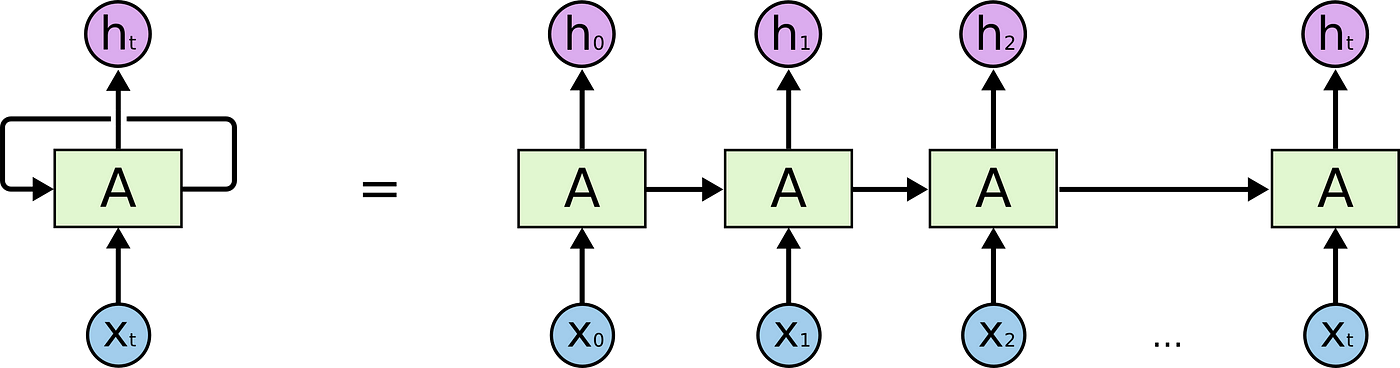

<p style="text-align:center">
    [Figura 1: Esquema simples sobre o funcionamento de uma RNN]
</p>

### **Aplicação dessa arquitetura em dados sequenciais** 🏦

<p style="text-align:justify;">
Dados sequencias são organizados de forma que a posição de cada elemento na sequência é relevante e, por isso, o contexto em que estão inseridas é importante. As RNNs são projetadas para lidar com dados sequenciais, pois utilizam a saída das etapas anteriores como entrada da etapa atual. Um exemplo comum de aplicação é a previsão da próxima palavra em programas de geração de texto automático ou tradutores, no qual a RNN considera cada palavra dentro da frase para fazer a previsão, para que assim, a expressão tenha sentido.
</p>

### **Importação das bibliotecas & dataset** 📚

<p style="text-align:justify;">
Para a realização da atividade escolhemos um dataset sobre previsão de sunspots, que se trata de manchas solares temporárias. Foram feitas medidas diárias no intervalo de 01/01/1818 e 31/01/2025. Com isso, buscamos prever a quantidade de manchas solares observadas por dia (descrito em dia, mês e ano).
</p>

In [1]:
# Importação dos dados
import zipfile
import os

# Módulos do Pytorch
import torch
import torch.nn as nn
import torch.optim as optim

# Demais bibliotecas
import pandas as pd
import random
from sklearn.preprocessing import MinMaxScaler
import math
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import copy

In [2]:
# !kaggle datasets download -d patrickfleith/daily-sunspots-dataset

In [3]:
with zipfile.ZipFile("daily-sunspots-dataset.zip", "r") as zip_ref:
    zip_ref.extractall("daily_sunspots-dataset")
os.listdir("daily_sunspots-dataset")

['daily_sunspots_time_series_1850-01_2025-01.csv']

### **Tratamento de dados** 💊

A partir da extração do arquivo zip, é possível obter o arquivo csv com os dados que serão utilizados.

In [4]:
df = pd.read_csv("daily_sunspots-dataset/daily_sunspots_time_series_1850-01_2025-01.csv")
display(df)

,date,year,month,day,date_frac,counts,std,nobs,indicator
0,1850-01-01,1850,1,1,1850.001,253,19.6,1,NaN
1,1850-01-02,1850,1,2,1850.004,162,15.5,1,NaN
2,1850-01-03,1850,1,3,1850.007,217,18.1,1,NaN
3,1850-01-04,1850,1,4,1850.010,99,12.0,1,NaN
4,1850-01-05,1850,1,5,1850.012,108,12.6,1,NaN
...,...,...,...,...,...,...,...,...,...
63944,2025-01-27,2025,1,27,2025.073,54,12.6,29,*
63945,2025-01-28,2025,1,28,2025.075,75,11.8,19,*
63946,2025-01-29,2025,1,29,2025.078,82,10.4,28,*
63947,2025-01-30,2025,1,30,2025.081,106,21.0,29,*


Com as colunas selecionadas, serão escolhidas as referentes a data dos fenômenos com atributos (dia, mês e ano) e o número de machas solares como alvo.

In [5]:
df  = df.loc[:, df.columns.isin(['date', 'year', 'month', 'day', 'counts'])]
display(df)

,date,year,month,day,counts
0,1850-01-01,1850,1,1,253
1,1850-01-02,1850,1,2,162
2,1850-01-03,1850,1,3,217
3,1850-01-04,1850,1,4,99
4,1850-01-05,1850,1,5,108
...,...,...,...,...,...
63944,2025-01-27,2025,1,27,54
63945,2025-01-28,2025,1,28,75
63946,2025-01-29,2025,1,29,82
63947,2025-01-30,2025,1,30,106


A partir disso, os dados serão divididos em três conjuntos: treino (80%), validação (10%) e teste (10%). Como os dados são sequenciais, o split não pode ser realizado de forma aleatória. Ou seja, precisamos separar os dados de forma ordenada, a fim de preservar a continuidade da série temporal.

In [6]:
X_treino, y_treino = df[['year', 'month', 'day']][:int(len(df)*0.8)], df['counts'][:int(len(df)*0.8)]
X_validacao, y_validacao = df[['year', 'month', 'day']][int(len(df)*0.8):int(len(df)*0.9)], df['counts'][int(len(df)*0.8):int(len(df)*0.9)]
X_teste, y_teste = df[['year', 'month', 'day']][int(len(df)*0.9):], df['counts'][int(len(df)*0.9):]

In [7]:
X_treino.shape

(51159, 3)

In [8]:
scaler_X = MinMaxScaler()
X_treino = scaler_X.fit_transform(X_treino.values)
X_validacao= scaler_X.transform(X_validacao.values)
X_teste = scaler_X.transform(X_teste.values)

scaler_y = MinMaxScaler()
y_treino = scaler_y.fit_transform(y_treino.values.reshape(-1, 1))
y_validacao= scaler_y.transform(y_validacao.values.reshape(-1, 1))
y_teste = scaler_y.transform(y_teste.values.reshape(-1, 1))
#y_teste = y_teste.values.reshape(-1, 1)

Com os conjuntos definidos, podemos transformá-los em tensores, a fim de garantir compatibilidade com a rede neural que será criada a partir da utilização do Pytorch.

In [9]:
X_treino = torch.tensor(X_treino, dtype=torch.float32)
X_validacao = torch.tensor(X_validacao, dtype=torch.float32) 
X_teste = torch.tensor(X_teste, dtype=torch.float32)

y_treino = torch.tensor(y_treino, dtype=torch.float32).view(-1, 1)
y_validacao = torch.tensor(y_validacao, dtype=torch.float32).view(-1, 1)
y_teste = torch.tensor(y_teste, dtype=torch.float32).view(-1, 1)

Em RNNs os dados, usualmente, são divididos em janelas, sendo que cada janela é utilizada para prever o próximo elemento. A partir disso, a janela vai "deslizando" ao longo da série temporal, considerando os resultados previstos anteriormente para a previsão dos próximos. A partir do número de dados (63949 instâncias), consideramos que 100 observações seria um tamanho razoável para a janela.

In [10]:
def criar_janelas(X, y, tamanho_janela):
    X_seq = []
    y_seq = []
    for i in range(len(X) - tamanho_janela):
        X_seq.append(X[i:i + tamanho_janela]) # os valores dentro desse intervalo
        y_seq.append(y[i + tamanho_janela]) # servirão para prever esse valor
    return torch.stack(X_seq), torch.stack(y_seq) # concatena para uma sequência de tensores em que (num_janelas, tamanho_da_sequencia, tamanho do input, nesse caso 4)

In [11]:
X_treino_janela, y_treino_janela = criar_janelas(X_treino, y_treino, 100)
X_validacao_janela, y_validacao_janela = criar_janelas(X_validacao, y_validacao,100)
X_teste_janela, y_teste_janela = criar_janelas(X_teste, y_teste,100)

Com isso, temos que o tensor formado terá as seguintes dimensões: quantidade de janelas (dada pela subtração do tamanho da janela ao número inicial de dados), tamanho da janela e tamanho das entradas (ou seja, quantidade de colunas consideradas, atributos ou alvo).

In [12]:
X_treino_janela.shape

torch.Size([51059, 100, 3])

### **Treinamento da RNN** 🏋🏻‍♀️

A partir do módulo "nn" da biblioteca "Pytorch", será possível criar a classe referente a RNN. Para instanciá-la, os parâmetros necessarios serão o tamanho da entrada, o tamanho do estado oculto e o tamanho da saída. Além disso, como hiperparâmetros, iremos definir a taxa de aprendizado como 0.001, o otimizador como Adam e a função de perda será calculada a partir do Mean Squared Error (MSE, do português, erro quadrático médio).

In [13]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        ultima_saida = out[:, -1, :]         
        out = self.fc(ultima_saida)
        return out

num_features = 3
hidden_size = 32
tamanho_saida = 1

rnn = RNN(num_features, hidden_size, tamanho_saida) 


In [14]:
fn_perda = nn.MSELoss()
otimizador = torch.optim.Adam(rnn.parameters(), lr=0.001) 

A fim de evitar o sobreajuste da rede, o conceito de parada antecipada será implementado, o qual consiste na interrupção do treinamento após a passagem de um determinado número de épocas - denominado paciência - em que não há diminuição do erro associado ao conjunto de validação. Além disso, os dados da perda dos dois conjuntos - referentes a cada época - serão armazenados em listas ("loss_treino_lista" e "loss_treino_validacao").

In [15]:
num_epocas = 500

menor_perda = float('inf')
pesos_menor_perda = None
paciencia = 10

loss_treino_lista = []
loss_validacao_lista = []

for epoca in range(num_epocas):

    rnn.train() # Modo de treinamento
    
    y_pred = rnn(X_treino_janela) # forward pass
    
    otimizador.zero_grad() # Zera os gradientes antes de calcular os novos

    loss_treino = fn_perda(y_pred, y_treino_janela) # Cálculo da função de perda (MSE)
    loss_treino_lista.append(round(loss_treino.item(), 4)) # Adiciona a perda à lista
    loss_treino.backward() # Backpropagation
    
    otimizador.step() # Atualização dos pesos

    rnn.eval()  # Modo de validação
    with torch.no_grad():  # Desativação do cálculo do gradiente
        y_pred_val = rnn(X_validacao_janela)
        loss_validacao = fn_perda(y_validacao_janela, y_pred_val)
        loss_validacao_lista.append(round(loss_validacao.item(), 2))

    if loss_validacao.item() < menor_perda:
        # Se a validação for menor do que a menor perda atual, definir como nova menor perda
        menor_perda = round(loss_validacao.item(), 6)
        pesos_menor_perda = copy.deepcopy(rnn.state_dict())  # E salvar os pesos do modelo       
        paciencia = 10
    else:
        paciencia -= 1
        if paciencia == 0:
            epoca_final = epoca
            print(f"Treinamento interrompido na época {epoca_final}")
            break
    print(f"Na época {epoca}, a perda do treino foi de {loss_treino} e a da validação foi de {loss_validacao} ")
rnn.load_state_dict(pesos_menor_perda) # Carrega os pesos do modelo com menor perda

Na época 0, a perda do treino foi de 0.03496771305799484 e a da validação foi de 0.0312577523291111 
Na época 1, a perda do treino foi de 0.029583251103758812 e a da validação foi de 0.0258935634046793 
Na época 2, a perda do treino foi de 0.02569657191634178 e a da validação foi de 0.022556552663445473 
Na época 3, a perda do treino foi de 0.023320142179727554 e a da validação foi de 0.021131636574864388 
Na época 4, a perda do treino foi de 0.022369511425495148 e a da validação foi de 0.021274233236908913 
Na época 5, a perda do treino foi de 0.022572610527276993 e a da validação foi de 0.02230234630405903 
Na época 6, a perda do treino foi de 0.023389603942632675 e a da validação foi de 0.02337040938436985 
Na época 7, a perda do treino foi de 0.02417868562042713 e a da validação foi de 0.023924445733428 
Na época 8, a perda do treino foi de 0.024542896077036858 e a da validação foi de 0.023856019601225853 
Na época 9, a perda do treino foi de 0.024423597380518913 e a da validação f

<All keys matched successfully>

### **Análise dos resultados** 📊

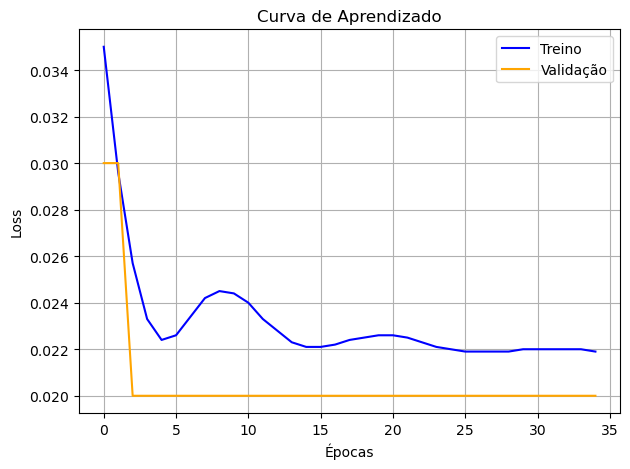

In [18]:
X_plot = list(range(0,35, 1))

plt.plot(X_plot, loss_treino_lista, label="Treino", color="blue")
plt.plot(X_plot, loss_validacao_lista, label="Validação", color="orange")

plt.title("Curva de Aprendizado")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

É possível notar um comportamento curioso na curva de aprendizado: o erro da validação desceu nas primeiras épocas e manteve-se praticamente constante até a ativação da parada antecipada. O conjunto de treino, por outro lado, apresentou comportamento irregular ao longo de todo o treinamento. 

Agora, é válido analisar o desempenho da rede na previsão dos dados de teste. Para isso, além do cálculo da raiz quadrada do erro quadrático médio (RMSE), será plotado um histograma comparando a distribuição dos dois conjuntos.

In [19]:
with torch.no_grad(): # não calcula os gradientes locais
    y_pred = rnn(X_teste_janela)

y_pred= scaler_y.inverse_transform(y_pred)
y_teste_janela = scaler_y.inverse_transform(y_teste_janela)

In [20]:
y_pred.shape

(6295, 1)

In [21]:
rmse = root_mean_squared_error(y_teste_janela, y_pred)
print(f"O RMSE da rede neural é: {rmse:.4f}")

O RMSE da rede neural é: 70.1839


In [22]:
media_dados_reais = np.mean(y_teste_janela)

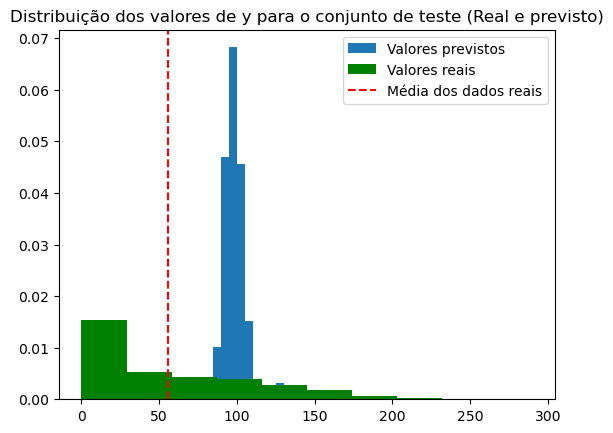

In [23]:
plt.hist(y_pred, density=True, label="Valores previstos")
plt.hist(y_teste_janela, density=True, label="Valores reais", color = "green")
plt.title("Distribuição dos valores de y para o conjunto de teste (Real e previsto)")
plt.axvline(media_dados_reais, linestyle="--", color="red", label="Média dos dados reais")
plt.legend()
plt.show();

De forma geral, é notável que a rede não conseguiu capturar os padrões dos dados de forma adequada, sendo que o RMSE, dado o intervalo obtido, foi consideravelmente alto. Além disso, a partir dos histogramas obtidos, é possível notar que os valores previstos não possuem distribuição próxima ao dos valores reais. 

### **Conclusão** 😁

Ao final, foi possível concluir que a RNN treinada não foi capaz de aprender os padrões presentes nos dados de entrada, o que foi comprovado pelo alto valor de RMSE e pelas notáveis diferenças entre as distribuições dos dados reais e previstos relativos ao conjunto de teste. 

Isso pode ter ocorrido porque a RNN treinada, de tipo padrão e portadora de apenas uma camada, pode ter sido simples demais para os dados escolhidos, os quais, além de buscarem a previsão de um fenômeno complexo baseado apenas nos dias definidos, são longos. Esse último fator pode estar atrelado a fenômenos conhecidos causadores de underfitting, como o desaparecimento do gradiente - caracterizado por sua ocorrência em redes neurais profundas, no qual os gradientes tendem a se aproximar de 0. Essa hipótese ganha mais força por meio da análise da curva de aprendizado, na qual é possível notar que os dados de treino apresentam maior erro do que os de validação, tornando mais improvável a hipótese de overfitting.

De forma geral, como perspectivas futuras, seria válido o teste de estruturas alternativas de RNN, tais como LSTMs e GNUs, que, por apresentarem maior complexidade, poderiam ser capazes de realizar previsões mais precisas para a os dados sequenciais utilizados. 

### **Referências!** 🗃️

[1] SACHINSONI. Recurrent Neural Networks (RNN) from Basic to Advanced. Disponível em: <https://medium.com/@sachinsoni600517/recurrent-neural-networks-rnn-from-basic-to-advanced-1da22aafa009>. Acesso em: 18 abr. 2025.

[2] Implementing Recurrent Neural Networks in PyTorch. GeeksforGeeks. Disponível em: <https://www.geeksforgeeks.org/implementing-recurrent-neural-networks-in-pytorch/>. Acesso em: 18 abr. 2025.

[3] deep-learning-v2-pytorch/recurrent-neural-networks/time-series/Simple_RNN.ipynb at master · udacity/deep-learning-v2-pytorch. GitHub. Disponível em: <https://github.com/udacity/deep-learning-v2-pytorch/blob/master/recurrent-neural-networks/time-series/Simple_RNN.ipynb>. Acesso em: 18 abr. 2025.

[4] O que é uma Rede Neural Recorrente (RNN)? | IBM. Disponível em: <https://www.ibm.com/br-pt/think/topics/recurrent-neural-networks>. Acesso em: 15 maio 2025.

[5] SINGH, Rishabh. Recurrent Neural Network (RNN). Disponível em: <https://medium.com/@RobuRishabh/recurrent-neural-network-rnn-8412b9abd755>. Acesso em: 15 maio 2025.

[6] INDRAJITBARAT. Recurrent Neural Networks (RNNs): Challenges and Limitations. Disponível em: <https://medium.com/@indrajitbarat9/recurrent-neural-networks-rnns-challenges-and-limitations-4534b25a394c>. Acesso em: 2 jun. 2025.
